# SSR-GAN Model

In [29]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, inc, outc, k, s, p, bn=True, subpix=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(inc, outc, kernel_size=k, stride=s, padding=p),
            nn.BatchNorm1d(outc) if bn else nn.Identity(),
            nn.LeakyReLU(0.2)
        )
        self.subpix = subpix
        if subpix:
            self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        if self.subpix:
            x = self.ps(x.unsqueeze(2))
            b, c, h, w = x.shape
            x = x.reshape(b, c * h, w)
        out = self.block(x)
        return out
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(129, 256, 7, 2, 3), # 16x256
            ConvBlock(256, 512, 5, 2, 2), # 8x512
            ConvBlock(512, 512, 3, 2, 1)  # 4x512
        )
        
        self.bottle = ConvBlock(512, 1024, 3, 2, 1) # 2x1024
        
        self.decoder = nn.Sequential(
            ConvBlock(512, 512, 3, 1, 1, subpix=True), # +4x512 skip
            ConvBlock(512, 512, 5, 1, 2, subpix=True), # +8x512 skip
            ConvBlock(512, 256, 7, 1, 3, subpix=True) # +16x256 skip
        )
        
        self.final = nn.Sequential(
            ConvBlock(256, 141, 7, 1, 3, subpix=True),
            ConvBlock(141, 141, 9, 1, 4, bn=False) # тут лрелу в конце!
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
        x = self.bottle(x)
        
        for layer in self.decoder:
            x = layer(x)
            x = torch.cat([x, skips.pop()], dim=1)

        out = self.final(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            ConvBlock(129 + 141, 1024, 7, 2, 3, bn=False),
            ConvBlock(1024, 1024, 5, 2, 2, bn=False),
            ConvBlock(1024, 1024, 3, 2, 1, bn=False),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
        )
   
    def forward(self, x):
        x = self.convs(x)
        out = self.fc(x)
        return out, torch.sigmoid(out)

## Losses

In [30]:
def reconstruction_loss(true, pred):
    return torch.mean(torch.sqrt(torch.mean(
                torch.square(torch.sub(true, pred)), dim=1)))

def regularization_term(fake_prob, real_prob, fake_logit, real_logit):
    real_grad = torch.autograd.grad(outputs=real_prob, inputs=real_logit,
                                grad_outputs=torch.ones_like(real_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    fake_grad = torch.autograd.grad(outputs=fake_prob, inputs=fake_logit,
                                grad_outputs=torch.ones_like(fake_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    
    ep = torch.mean(torch.square(1 - real_prob) * torch.square(torch.norm(real_grad)))
    eq = torch.mean(torch.square(fake_prob) * torch.square(torch.norm(fake_grad)))
    return ep + eq

def disc_loss(fake_prob, real_prob):
    return torch.mean(torch.log(real_prob)) + torch.mean(torch.log(1 - fake_prob))

def gen_loss(fake_prob):
    return torch.mean(-torch.log(fake_prob))

def segsnr(true, pred):
    return torch.mean(10 * torch.log(torch.div(
                torch.mean(torch.square(true), 2), 
                torch.mean(torch.square(true - pred), 2))), 1)

### Test

In [31]:
G = Generator()
D = Discriminator()
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4)  # 1e-5 after 50 epoch
optimizerD = torch.optim.RMSprop(D.parameters(), lr=1e-4)  # 1e-5 after 50 epoch
gamma = 1
lambd = 0.5
batch = 64

In [32]:
real_lf = torch.rand(batch, 129, 32)
real_hf = torch.rand(batch, 141, 32)
fake_hf = G(real_lf)
fake_full = torch.cat([real_lf, fake_hf], dim=1)
real_full = torch.cat([real_lf, real_hf], dim=1)
fake_logit, fake_prob = D(fake_full)
real_logit, real_prob = D(real_full)

# segsnr(real_full, fake_full)

In [33]:
lossD = disc_loss(fake_prob, real_prob) + 0.5 * gamma * regularization_term(fake_prob, real_prob, fake_logit, real_logit)
lossG = gen_loss(fake_prob) + lambd * reconstruction_loss(real_full, fake_full)
lossD.backward(retain_graph=True)
lossG.backward()

In [34]:
lossD.item(), lossG.item()

(-0.3867197632789612, 0.8751531839370728)

## Preprocessing and SSR-System

In [35]:
from scipy.io import wavfile
from pesq import pesq

import torchaudio
import matplotlib.pyplot as plt

import numpy as np

rate, ref = wavfile.read("5_gt.wav")
rate, deg = wavfile.read("5_gen.wav")
wavfile.write('5_gt_2.wav', rate, ref)
print(rate)
print(pesq(rate, ref, deg, 'wb'))

16000
1.6282330751419067


In [36]:
# 32 ms window size, 8 ms hop size
# the log and power operations to obtain LPS
# chopped up the utterances into T=32 timesteps


#######DONE######
# For our method, we applied the band-limited sinc interpolation method described in [34] 
# to the high-resolution signal and obtained the downsampled signal
# We applied a low-pass filter and downsampled the highresolution signals 
# to obtain their parallel low-resolution signals
# for training and testing

################TODO
# to create an artificial phase by flipping
# the narrowband phase and reverting the sign. 
# For the 2x superresolution version, we concatenate this flipped phase with the
# narrowband phase to obtain an artificial phase XˆP of the entire wideband signal. 
# In this work, we simply flipped the phase of the lowresolution 
# signal as the phase of the high-frequency range of the SSR output. 

# To improve our results, we considered Griffin-Lim algorithm 

# Finally, inverse STFT is applied to the complex spectrogram
# calculated from the estimated wideband LPS XSR and artificial phase Xˆ
# P , and the time domain signal yˆ is reconstructed
# using the overlap-add method.

## STFT / Spectrogram / mag+phase

In [37]:
hann = False # False then is "window of ones"
power = 2.0 # None (spec is just stft) or 1.0 (spec is magnitude) or 2.0 (spec is squared magnitude)

win = lambda x: torch.ones(x) if not hann else torch.hann_window(x)
def lps(x):
    # log power spectrogram
    if power is None or x.ndim == 3:
        return torch.square(x[:,:,0]).log()
    elif power == 1:
        return torch.square(x).log()
    elif power == 2:
        return x.log()


spec_kwargs = dict(n_fft=(141 + 129) * 2 - 1, win_length=32, hop_length=8, normalized=False)
to_spec = torchaudio.transforms.Spectrogram(**spec_kwargs, power=power, window_fn=win)

ref_ = torch.tensor(ref.copy())

spec = to_spec(ref_)
stft = torch.stft(ref_, **spec_kwargs, window=win(spec_kwargs['win_length']))
m, p = torchaudio.functional.magphase(stft)
stft.shape, spec.shape, m.shape, p.shape

(torch.Size([270, 2048, 2]),
 torch.Size([270, 2048]),
 torch.Size([270, 2048]),
 torch.Size([270, 2048]))

In [38]:
def mag_from_spec(spec):
    if power is not None:
        return torch.pow(spec, 1 / power)
    else:
        return torchaudio.functional.complex_norm(spec)

In [39]:
(mag_from_spec(spec) == m).all().item()

True

## Downsampling with the band-limited sinc interpolation

In [41]:
import resampy
rate_div = 4
ref_small = resampy.resample(ref, rate, rate // rate_div, axis=0, filter='sinc_window', num_zeros=64)
ref.shape, ref_small.shape

((16384,), (4096,))

In [42]:
import IPython
IPython.display.Audio(ref, rate=rate)

In [43]:
IPython.display.Audio(ref_small, rate=rate // rate_div)

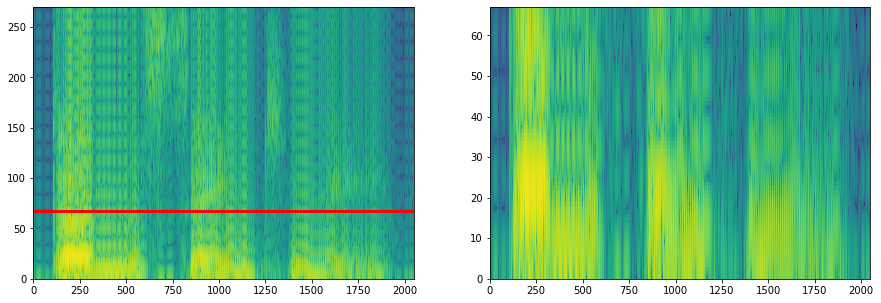

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(lps(to_spec(ref_)))
plt.hlines(spec.shape[0] // rate_div, 0, spec.shape[1], colors='r', linewidth=3)
plt.subplot(122)
plt.pcolormesh(lps(spec[:spec.shape[0]//4]))
plt.show()

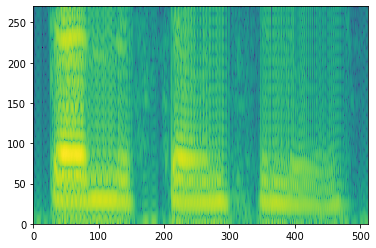

In [45]:
spec_small = to_spec(torch.tensor(ref_small.copy()))
plt.pcolormesh(lps(spec_small))
plt.show()

## STFT from Mag and Phase

In [46]:
def from_mag_phase(m, p):
    return torch.cat([(m * torch.cos(p)).unsqueeze(-1), 
                      (m * torch.sin(p)).unsqueeze(-1)], -1)
    

In [47]:
np.isclose(from_mag_phase(m, p), stft).mean()

0.9990080656828704

In [48]:
# ху***й code

def product(first, second):
    result = torch.empty_like(first)
    result[..., 0] = first[..., 0] * second[..., 0] -\
                     first[..., 1] * second[..., 1]
    result[..., 1] = first[..., 0] * second[..., 1] +\
                     first[..., 1] * second[..., 0]
    return result
def from_real_and_imag(real, imag):
    assert real.shape == imag.shape
    result = torch.stack([real, imag])
    result = result.permute(*cycle_permutation(real.dim() + 1, True))
    return result
def cycle_permutation(n, backward):
    if not backward:
        permutation = [n - 1] + list(range(n - 1))
    else:
        permutation = list(range(1, n)) + [0]
    return permutation
def phase(angle):
    cos = torch.cos(angle)
    sin = torch.sin(angle)
    return from_real_and_imag(cos, sin)

stft_pred = product(
            from_real_and_imag(
                m, torch.zeros_like(m)
            ),
            phase(torchaudio.functional.angle(stft)))

In [49]:
np.isclose(stft_pred, stft).mean()

0.9990080656828704

## Wave from STFT 

### istft

In [50]:
ref_pred = torchaudio.functional.istft(from_mag_phase(m, p), **spec_kwargs)
np.isclose(ref_pred, ref[:ref_pred.shape[0]]).mean()

1.0

In [51]:
np.isclose(torchaudio.functional.istft(stft_pred, **spec_kwargs), ref[:16377]).mean()

1.0

In [52]:
IPython.display.Audio(torchaudio.functional.istft(stft_pred, **spec_kwargs), rate=rate)

### Griffin-Lim (from spectrogram)

In [53]:
hann = True # False then is "window of ones"
to_spec = torchaudio.transforms.Spectrogram(**spec_kwargs, power=power, window_fn=win)
to_wave = torchaudio.transforms.GriffinLim(**spec_kwargs)

In [54]:
IPython.display.Audio(to_wave(to_spec(ref_) ** (1 / power)), rate=rate)

# Train заLoop

In [77]:
def run_epoch(dloader):
    for bidx, batch in enumerate(dloader, 1):
        uttname, clean, noisy, slice_idx = batch
import json
import sys
sys.path.append("../segan_pytorch")
from segan_pytorch.segan.datasets import se_dataset

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

opts = AttrDict(json.loads('''{
  "save_path": "ckpt_segan+",
  "d_pretrained_ckpt": null,
  "g_pretrained_ckpt": null,
  "cache_dir": "data_tmp",
  "clean_trainset": "/home/sorain/my_wham/train/clean",
  "noisy_trainset": "/home/sorain/my_wham/train/noisy",
  "clean_valset": null,
  "noisy_valset": null,
  "h5_data_root": null,
  "h5": false,
  "data_stride": 0.5,
  "seed": 111,
  "epoch": 100,
  "patience": 100,
  "batch_size": 300,
  "save_freq": 50,
  "slice_size": 16384,
  "opt": "rmsprop",
  "l1_dec_epoch": 100,
  "l1_weight": 100,
  "l1_dec_step": 1e-05,
  "g_lr": 5e-05,
  "d_lr": 5e-05,
  "preemph": 0.95,
  "max_samples": null,
  "eval_workers": 2,
  "slice_workers": 1,
  "num_workers": 1,
  "no_cuda": false,
  "random_scale": [
    1
  ],
  "no_train_gen": false,
  "preemph_norm": false,
  "wsegan": false,
  "aewsegan": false,
  "vanilla_gan": false,
  "no_bias": true,
  "n_fft": 2048,
  "reg_loss": "l1_loss",
  "skip_merge": "concat",
  "skip_type": "alpha",
  "skip_init": "one",
  "skip_kwidth": 11,
  "gkwidth": 31,
  "genc_fmaps": [
    64,
    128,
    256,
    512,
    1024
  ],
  "genc_poolings": [
    4,
    4,
    4,
    4,
    4
  ],
  "z_dim": 1024,
  "gdec_fmaps": null,
  "gdec_poolings": null,
  "gdec_kwidth": null,
  "gnorm_type": null,
  "no_z": false,
  "no_skip": false,
  "pow_weight": 0.001,
  "misalign_pair": false,
  "interf_pair": false,
  "denc_fmaps": [
    64,
    128,
    256,
    512,
    1024
  ],
  "dpool_type": "none",
  "dpool_slen": 16,
  "dkwidth": null,
  "denc_poolings": [
    4,
    4,
    4,
    4,
    4
  ],
  "dnorm_type": "bnorm",
  "phase_shift": 5,
  "sinc_conv": false,
  "bias": false
}'''))

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from segan.models import SEGAN, WSEGAN, AEWSEGAN
from segan.datasets import SEDataset, SEH5Dataset, collate_fn
from segan.utils import Additive
import numpy as np
import random
import json
import os



def main(opts):
    # select device to work on 
    device = 'cpu'
    if torch.cuda.is_available and not opts.no_cuda:
        device = 'cuda'
        opts.cuda = True
    CUDA = (device == 'cuda')
    # seed initialization
    random.seed(opts.seed)
    np.random.seed(opts.seed)
    torch.manual_seed(opts.seed)
    if CUDA:
        torch.cuda.manual_seed_all(opts.seed)
    # create SEGAN model
    if opts.wsegan:
        segan = WSEGAN(opts)
    elif opts.aewsegan:
        segan = AEWSEGAN(opts)
    else:
        segan = SEGAN(opts)     
    segan.to(device)
    # possibly load pre-trained sections of networks G or D
    print('Total model parameters: ',  segan.get_n_params())
    if opts.g_pretrained_ckpt is not None:
        segan.G.load_pretrained(opts.g_pretrained_ckpt, True)
    if opts.d_pretrained_ckpt is not None:
        segan.D.load_pretrained(opts.d_pretrained_ckpt, True)
    # create Dataset(s) and Dataloader(s)
    if opts.h5:
        # H5 Dataset with processed speech chunks
        if opts.h5_data_root is None:
            raise ValueError('Please specify an H5 data root')
        dset = SEH5Dataset(opts.h5_data_root, split='train',
                           preemph=opts.preemph,
                           verbose=True,
                           random_scale=opts.random_scale)
    else:
        # Directory Dataset from raw wav files
        dset = SEDataset(opts.clean_trainset, 
                         opts.noisy_trainset, 
                         opts.preemph,
                         do_cache=True,
                         cache_dir=opts.cache_dir,
                         split='train',
                         stride=opts.data_stride,
                         slice_size=opts.slice_size,
                         max_samples=opts.max_samples,
                         verbose=True,
                         slice_workers=opts.slice_workers,
                         preemph_norm=opts.preemph_norm,
                         random_scale=opts.random_scale
                        )
    dloader = DataLoader(dset, batch_size=opts.batch_size,
                         shuffle=True, num_workers=opts.num_workers,
                         pin_memory=CUDA,
                         collate_fn=collate_fn)
    if opts.clean_valset is not None:
        if opts.h5:
            dset = SEH5Dataset(opts.h5_data_root, split='valid',
                               preemph=opts.preemph,
                               verbose=True)
        else:
            va_dset = SEDataset(opts.clean_valset, 
                                opts.noisy_valset, 
                                opts.preemph,
                                do_cache=True,
                                cache_dir=opts.cache_dir,
                                split='valid',
                                stride=opts.data_stride,
                                slice_size=opts.slice_size,
                                max_samples=opts.max_samples,
                                verbose=True,
                                slice_workers=opts.slice_workers,
                                preemph_norm=opts.preemph_norm)
        va_dloader = DataLoader(va_dset, batch_size=300,
                                shuffle=False, num_workers=opts.num_workers,
                                pin_memory=CUDA,
                                collate_fn=collate_fn)
    else:
        va_dloader = None
    criterion = nn.MSELoss()
    return segan, dloader, va_dloader

segan, dloader, va_dloader = main(opts)

Initialzing weight to 0.0, 0.02 for module:  Conv1d(1, 64, kernel_size=(31,), stride=(4,), bias=False)
Initialzing weight to 0.0, 0.02 for module:  Conv1d(64, 128, kernel_size=(31,), stride=(4,), bias=False)
Initialzing weight to 0.0, 0.02 for module:  Conv1d(128, 256, kernel_size=(31,), stride=(4,), bias=False)
Initialzing weight to 0.0, 0.02 for module:  Conv1d(256, 512, kernel_size=(31,), stride=(4,), bias=False)
Initialzing weight to 0.0, 0.02 for module:  Conv1d(512, 1024, kernel_size=(31,), stride=(4,), bias=False)
Generator:  Generator(
  (enc_blocks): ModuleList(
    (0): GConv1DBlock(
      (conv): Conv1d(1, 64, kernel_size=(31,), stride=(4,), bias=False)
      (act): PReLU(num_parameters=64)
    )
    (1): GConv1DBlock(
      (conv): Conv1d(64, 128, kernel_size=(31,), stride=(4,), bias=False)
      (act): PReLU(num_parameters=128)
    )
    (2): GConv1DBlock(
      (conv): Conv1d(128, 256, kernel_size=(31,), stride=(4,), bias=False)
      (act): PReLU(num_parameters=256)
    

In [59]:
seg

In [61]:
dataset = se_dataset.SEDataset("/home/sorain/my_wham/train/clean","/home/sorain/my_wham/train/noisy", 0.95)

Creating train split out of data in /home/sorain/my_wham/train/clean
Found 20001 clean names and 20001 noisy names


In [68]:
dloader = torch.utils.data.DataLoader(dataset, batch_size=batch)

In [63]:
for fig in dloader:
    print(fig)
    break

[('6297', '6297', '6297', '6297', '6297', '6297', '7413', '7413', '7413', '7413', '14303', '14303', '14303', '6670', '6670', '14616', '14616', '14616', '14616', '14616', '2595', '2595', '2595', '2595', '2595', '2595', '2120', '2120', '2120', '2120', '6936', '6936', '6936', '6936', '412', '412', '412', '412', '412', '16529', '16529', '16529', '16529', '16529', '16529', '16529', '6136', '6136', '6136', '6136', '8685', '8685', '8685', '8685', '8685', '8685', '11975', '11975', '11975', '11975', '11975', '12402', '12402', '14946'), tensor([[ 3.0365e-03,  2.5628e-03, -5.5161e-04,  ...,  2.1592e-04,
          2.4338e-04,  1.5030e-04],
        [-7.4006e-05, -9.9184e-06, -3.4333e-05,  ...,  2.6329e-03,
          2.0928e-03,  1.3649e-03],
        [ 3.2731e-04,  3.3036e-04,  2.4186e-04,  ..., -7.5303e-04,
         -5.7298e-04, -6.5843e-04],
        ...,
        [ 1.6327e-03,  1.4244e-03, -1.2589e-04,  ...,  4.4080e-02,
         -5.0439e-03,  6.1288e-03],
        [ 8.7510e-04,  5.4856e-04,  8.7663

In [27]:
for bidx, batch in enumerate(dloader, start=1):
    uttname, clean, noisy, slice_idx = batch
    clean = clean.unsqueeze(1)
    noisy = noisy.unsqueeze(1)
    label.resize_(clean.size(0)).fill_(1)
    clean = clean.to(device)
    noisy = noisy.to(device)

In [28]:
# from segan_pytorch.segan.datasets import se_dataset
# dset = se_dataset.SEDataset(clean_dir, noisy_dir, 0, slice_size=270)
# dloader = DataLoader(dset, batch_size=batch_size,
#                          shuffle=True, num_workers=num_workers,
#                          pin_memory=True,
#                          collate_fn=se_dataset.collate_fn)
# for bidx, batch in enumerate(dloader, start=1):
#     uttname, clean, noisy, slice_idx = batch
#     print(clean.shape)
#     break